In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # PathMNIST has 3 channels
])

train_ds = ImageFolder("data/train", transform=transform)
val_ds = ImageFolder("data/val", transform=transform)
test_ds = ImageFolder("data/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

In [3]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 9)  # PathMNIST has 9 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1/15, Loss: 1105.5991, Accuracy: 70.90%
Epoch 2/15, Loss: 699.5944, Accuracy: 81.63%
Epoch 3/15, Loss: 578.2904, Accuracy: 84.98%
Epoch 4/15, Loss: 500.5607, Accuracy: 87.14%
Epoch 5/15, Loss: 447.7993, Accuracy: 88.61%
Epoch 6/15, Loss: 404.8726, Accuracy: 89.49%
Epoch 7/15, Loss: 367.9168, Accuracy: 90.40%
Epoch 8/15, Loss: 337.7069, Accuracy: 91.24%
Epoch 9/15, Loss: 314.0649, Accuracy: 91.95%
Epoch 10/15, Loss: 289.9575, Accuracy: 92.45%
Epoch 11/15, Loss: 274.7785, Accuracy: 92.89%
Epoch 12/15, Loss: 255.1551, Accuracy: 93.52%
Epoch 13/15, Loss: 243.6866, Accuracy: 93.76%
Epoch 14/15, Loss: 225.8281, Accuracy: 94.13%
Epoch 15/15, Loss: 221.7049, Accuracy: 94.24%


In [6]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

if test_total > 0:
    print('Test Accuracy: %.2f %%' % (100 * test_correct / test_total))
else:
    print("Test set appears to be empty.")


Test Accuracy: 79.41 %


In [10]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def attack(model, data_loader, epsilon):
    import torch.nn as nn
    loss_fn = nn.CrossEntropyLoss()
    correct = 0
    adv_examples = []
    model.eval()

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        outputs = model(images)
        init_preds = outputs.max(1, keepdim=True)[1]

        loss = loss_fn(outputs, labels)
        model.zero_grad()
        loss.backward()

        data_grad = images.grad.data
        perturbed_data = fgsm_attack(images, epsilon, data_grad)

        final_outputs = model(perturbed_data)
        final_preds = final_outputs.max(1, keepdim=True)[1]

        correct += final_preds.eq(labels.view_as(final_preds)).sum().item()

        # Store adversarial examples for visualization
        if len(adv_examples) < 5:
            adv_examples.append((images[0].detach(), labels[0].detach(), perturbed_data[0].detach()))

    final_acc = correct / len(data_loader.dataset)
    print(f"FGSM Epsilon: {epsilon}\tTest Accuracy = {final_acc:.4f}")
    return final_acc, adv_examples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FGSM Epsilon: 0.01	Test Accuracy = 0.2385


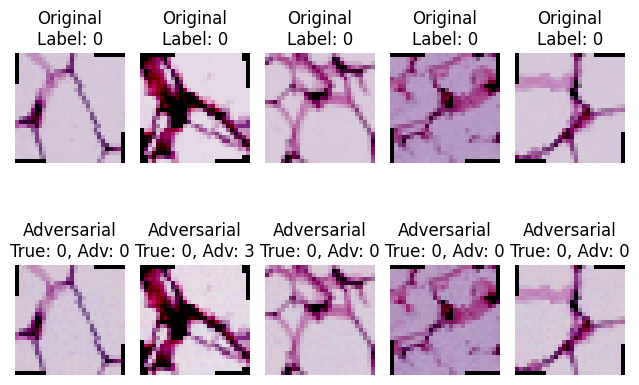

In [11]:
def imshow(img, label, adv_label=None, title=''):
    img = img.detach().cpu().squeeze()  # Detach before converting
    if img.ndim == 3:
        img = img.permute(1, 2, 0).numpy()
    else:
        img = img.numpy()
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    if adv_label is not None:
        plt.title(f'{title}\nTrue: {label}, Adv: {adv_label}')
    else:
        plt.title(f'{title}\nLabel: {label}')
    plt.axis('off')


acc, adv_samples = attack(model, test_loader, epsilon=0.01)
for i, (img, label, adv_img) in enumerate(adv_samples):
    plt.subplot(2, 5, i + 1)
    imshow(img, label.item(), title="Original")
    plt.subplot(2, 5, i + 6)
    pred = model(adv_img.unsqueeze(0)).argmax(1).item()
    imshow(adv_img, label.item(), pred, title="Adversarial")
plt.tight_layout()
plt.show()


Running attack with epsilon = 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FGSM Epsilon: 0.0	Test Accuracy = 0.4220
Test Accuracy under attack (ε=0.0): 0.42%


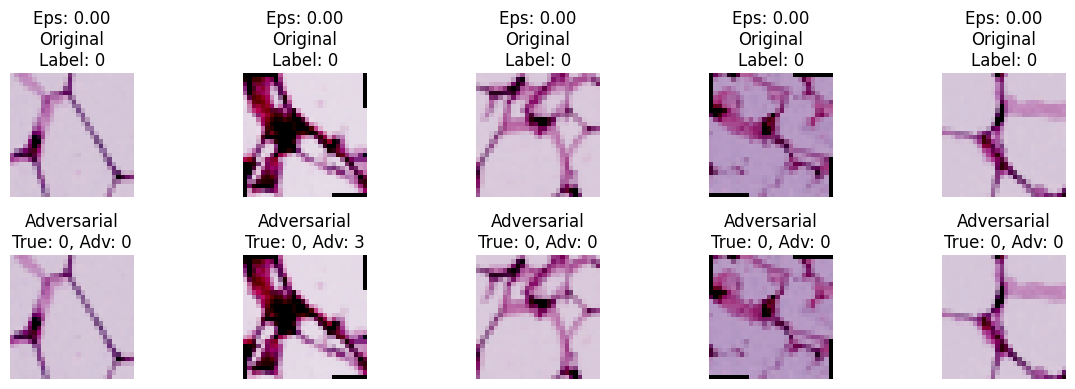

Running attack with epsilon = 0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FGSM Epsilon: 0.01	Test Accuracy = 0.2428
Test Accuracy under attack (ε=0.01): 0.24%


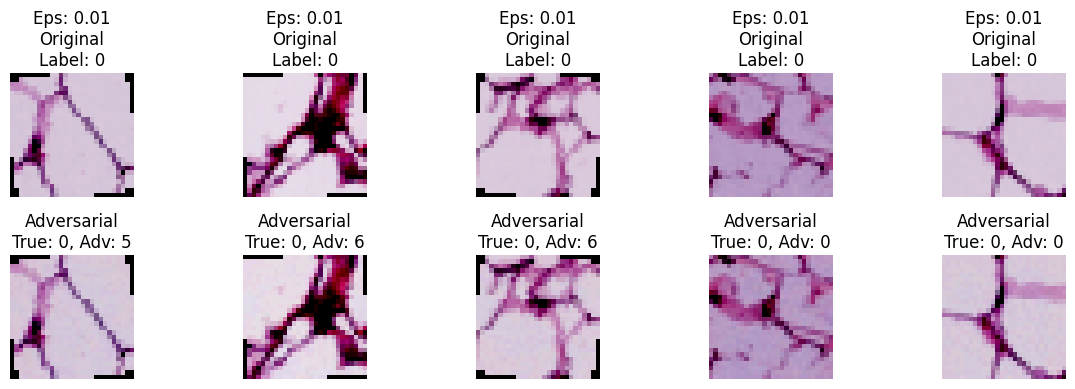

Running attack with epsilon = 0.05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FGSM Epsilon: 0.05	Test Accuracy = 0.0719
Test Accuracy under attack (ε=0.05): 0.07%


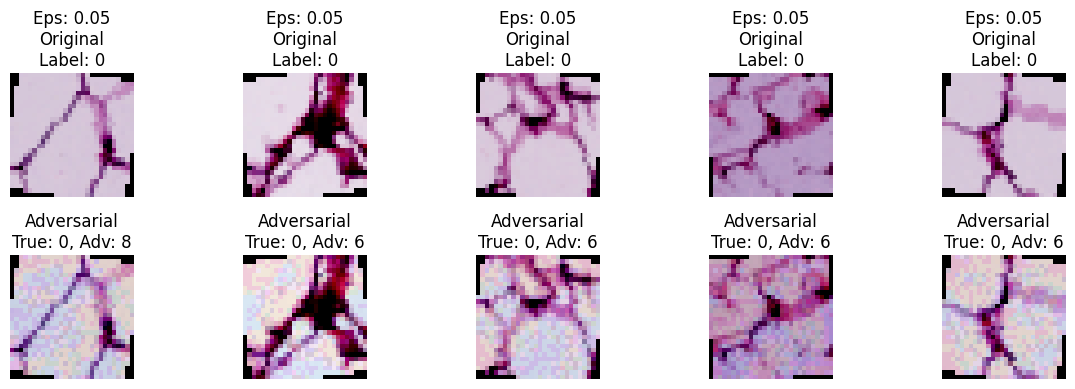

Running attack with epsilon = 0.1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FGSM Epsilon: 0.1	Test Accuracy = 0.0488
Test Accuracy under attack (ε=0.1): 0.05%


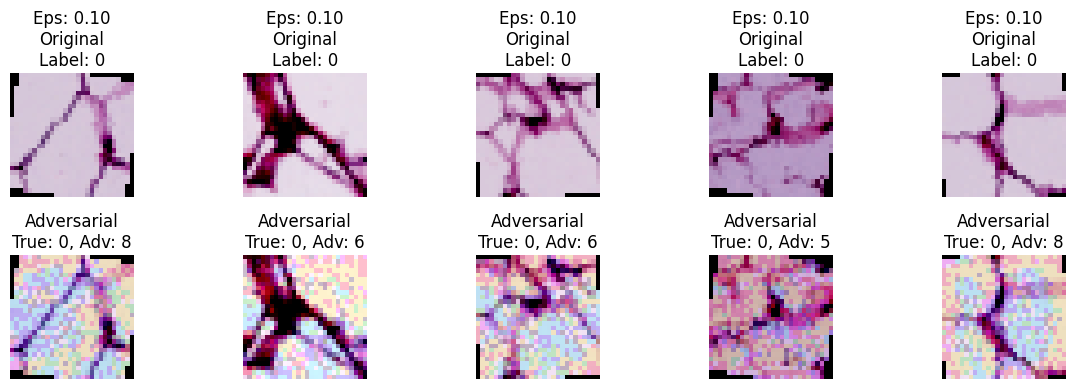

Running attack with epsilon = 0.15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FGSM Epsilon: 0.15	Test Accuracy = 0.0809
Test Accuracy under attack (ε=0.15): 0.08%


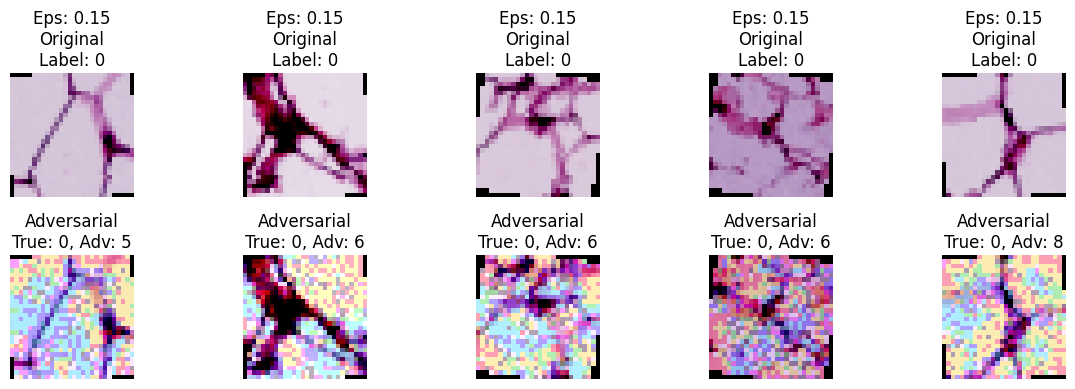

In [12]:
epsilons = [0.0, 0.01, 0.05, 0.1, 0.15]
num_examples = 5  # Number of samples to visualize per epsilon

def imshow(img, label, adv_label=None, title=''):
    img = img.detach().cpu().squeeze()
    if img.ndim == 3:
        img = img.permute(1, 2, 0).numpy()
    else:
        img = img.numpy()
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
    if adv_label is not None:
        plt.title(f'{title}\nTrue: {label}, Adv: {adv_label}')
    else:
        plt.title(f'{title}\nLabel: {label}')
    plt.axis('off')

for eps in epsilons:
    print(f"Running attack with epsilon = {eps}")
    acc, adv_samples = attack(model, test_loader, epsilon=eps)
    print(f"Test Accuracy under attack (ε={eps}): {acc:.2f}%")

    plt.figure(figsize=(12, 4))
    for i, (img, label, adv_img) in enumerate(adv_samples[:num_examples]):
        plt.subplot(2, num_examples, i + 1)
        imshow(img, label.item(), title=f"Eps: {eps:.2f}\nOriginal")

        plt.subplot(2, num_examples, i + 1 + num_examples)
        pred = model(adv_img.unsqueeze(0).to(device)).argmax(1).item()
        imshow(adv_img, label.item(), pred, title="Adversarial")

    plt.tight_layout()
    plt.show()


In [13]:
torch.save(model.state_dict(), 'model_pathmnist.pth')